In [37]:
import os
import re
import pandas as pd
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sqlalchemy import create_engine
from nostril import nonsense_detector as nd
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from gensim.models import Doc2Vec
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm

In [38]:
# data
def get_data():
  engine_name = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
  engine = create_engine(engine_name)

  query_sql = "SELECT * FROM fb_data"
  df = pd.read_sql_query(query_sql, con=engine)
  return df

def process_text(text):
  TAG_RE = re.compile(r'<[^>]+>')
  URL_RE = re.compile(r'http[s]?://\S+')
  text = URL_RE.sub('', text)
  text = TAG_RE.sub('',text)
  text = re.sub('[^a-zA-Z]', ' ', text)
  text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return simple_preprocess(text, deacc=True)

def map_label_to_class(label):
  SOURCES = {
    0: ["nytimes","cnn","nbc"],
    1: ["FoxNews","DailyMail","NYPost"],
    2: ["bbcnews","Reuters","APNews"]
  }

  for class_label, sources in SOURCES.items():
      if label in sources:
          return class_label
  raise ValueError(f"Label '{label}' not found in any source categories.")


def process_data(df):
  df['text'] = df['text'].apply(process_text)
  df['source'] = df['source'].apply(map_label_to_class)
  df.drop(columns=['id'])

  return df

def display_data(df):
  label_counts = df['source'].value_counts().sort_index()
  plt.bar(label_counts.index, label_counts.values, color=['blue', 'red', 'green'])
  plt.xticks(label_counts.index, ['left', 'right', 'center'])  
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.title('Count of Labels')
  plt.show()

In [39]:
# doc 2 vec
def create_d2v(path,df):
  print('Training Doc2vec Model')
  tagged = df.apply(
      lambda row: TaggedDocument(words=row['text'], tags=[row['source']]), axis=1
  ).tolist()
  d2v_model = Doc2Vec(dm=0,vector_size=100,window=2,min_count=1,workers=4,epochs=20)
  d2v_model.build_vocab(tagged)
  d2v_model.train(utils.shuffle(tagged),total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
  d2v_model.save(path+'.model')
  print('Finished Training!!!')

  word_vectors = {word: d2v_model.wv[word].tolist() for word in d2v_model.wv.index_to_key}
    
  with open(path+'.json', 'w') as f:
    json.dump(word_vectors, f)

  return d2v_model

In [40]:
# dataset initialization
class FBData(Dataset):
  def __init__(self,df,d2v_model):
    df.drop(columns=['id'])
    
    self.data = df
    self.d2v = d2v_model
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    text = self.data['text'][idx]
    label = self.data['source'][idx]
    vectorized_text = self.d2v.infer_vector(text)
    return torch.tensor(vectorized_text),torch.tensor(label)


In [41]:
# model

class BiasClassificationModel(nn.Module):
  def __init__(self,input_size,hidden_dim_1,hidden_dim_2,num_class):
    super(BiasClassificationModel,self).__init__()
    self.fc1 = nn.Linear(input_size,hidden_dim_1)
    self.fc2 = nn.Linear(hidden_dim_1,hidden_dim_2)
    self.fc3 = nn.Linear(hidden_dim_2,num_class)
    self.activation = nn.LeakyReLU()
  
  def forward(self,text):
    output = self.activation(self.fc1(text))
    output = self.activation(self.fc2(output))
    output = self.fc3(output)
    return F.softmax(output,dim=1)

In [42]:
# split data 
def split_data(dataset,batch_size):
  train_idx, test_idx = train_test_split(range(len(dataset)),test_size=0.2,random_state=42,shuffle=True)
  train_dataset = Subset(dataset,train_idx)
  test_dataset = Subset(dataset,test_idx)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
  return train_loader, test_loader

In [43]:
# train and test
def train(dataloader,model,optimizer,criterion,verbose):
  model.train()
  train_loss = 0
  train_acc = 0
  total_samples = 0

  for text,label in tqdm(dataloader, disable=not verbose):
    optimizer.zero_grad()

    output = model(text)
    loss = criterion(output,label)

    train_loss += loss.item()
    train_acc += (output.argmax(1) == label).sum().item()
    total_samples += text.size(0)

    loss.backward()
    optimizer.step()

  train_loss/=total_samples
  train_acc/=total_samples

  return train_loss, train_acc, model, optimizer, criterion

def test(dataloader,model,criterion, verbose):
  model.eval()
  test_loss = 0
  test_acc = 0
  total_samples = 0
  test_preds = []
  test_labels = []

  with torch.no_grad():
    for text,label in tqdm(dataloader,disable=not verbose):
      output = model(text)
      loss = criterion(output,label)
  
      test_loss += loss.item()
      test_acc += (output.argmax(1) == label).sum().item()
      total_samples += text.size(0)

      test_preds.extend(output.argmax(1).cpu().numpy())
      test_labels.extend(label.cpu().numpy())
      
  test_loss/=total_samples
  test_acc/=total_samples
  return test_loss,test_acc, test_preds, test_labels

def train_test_loop(path,train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose):
  print('Training Classification NN Starting')

  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(num_epochs):
    train_loss, train_acc, model, optimizer, criterion = train(train_loader,model,optimizer,criterion,verbose)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    if verbose: print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

    test_loss, test_acc, test_preds, test_labels  = test(test_loader,model,criterion,verbose)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if verbose: print(f'Test Epoch [{epoch + 1}/{num_epochs}], Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')
  
  torch.save(model.state_dict(),path+'.pth')

  model.eval()
  input, _ = next(iter(test_loader))
  dummy_input = torch.randn(1,input.shape[1])
  torch.onnx.export(
    model,
    dummy_input,
    path+'.onnx',
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output']
  )

  print('Model Saved - Training Done, Final Testing Results Are As Shown:')
  print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
  print(f'Test Epoch [{epoch + 1}/{num_epochs}], Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')

  plt.plot(train_losses,label='Train Loss')
  plt.plot(test_losses,label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(train_accs,label='Train Acc')
  plt.plot(test_accs,label='Test Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy %')
  plt.legend()
  plt.show()

  cm = confusion_matrix(test_labels, test_preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
  disp.plot(cmap='Blues')
  plt.title('Confusion Matrix: Predicted vs Actual Labels')
  plt.show()

  return model

In [44]:
# predict
def predict_text(text,model,d2v_model):
  tokenized_text = process_text(text)
  vectorized_text = torch.tensor(d2v_model.infer_vector(tokenized_text)).unsqueeze(0)
  output = model(vectorized_text).detach().numpy().flatten()
  prediction = output.argmax()

  label_map = {0: 'left', 1: 'right', 2: 'center'}
  prediction = label_map.get(prediction, 'Prediction error.')

  probabilities_percentage = [f"{p * 100:.1f}%" for p in output]

  print(f'The text provided leans towards {prediction} with a probability of '
          f'{probabilities_percentage[0]} for left, {probabilities_percentage[1]} for right, and '
          f'{probabilities_percentage[2]} for center.')

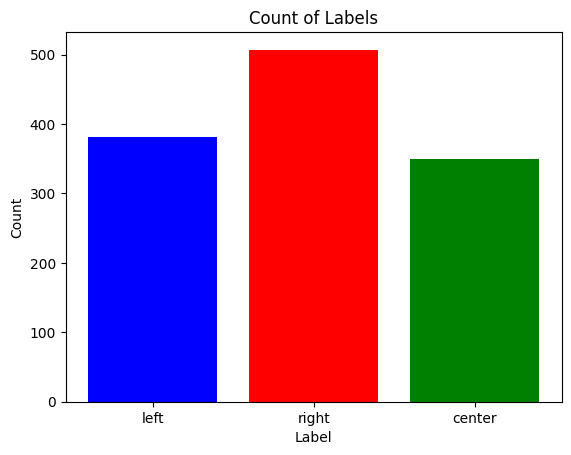

Training Doc2vec Model
Finished Training!!!
Training Classification NN Starting


100%|██████████| 495/495 [00:01<00:00, 353.91it/s]


Training Epoch [1/5], Loss: 0.3683, Accuracy: 0.8899


100%|██████████| 124/124 [00:00<00:00, 559.99it/s]


Test Epoch [1/5], Loss: 0.2975, Accuracy: 0.9758


100%|██████████| 495/495 [00:01<00:00, 364.48it/s]


Training Epoch [2/5], Loss: 0.2952, Accuracy: 0.9758


100%|██████████| 124/124 [00:00<00:00, 573.20it/s]


Test Epoch [2/5], Loss: 0.3014, Accuracy: 0.9556


100%|██████████| 495/495 [00:01<00:00, 322.80it/s]


Training Epoch [3/5], Loss: 0.2907, Accuracy: 0.9758


100%|██████████| 124/124 [00:00<00:00, 664.20it/s]


Test Epoch [3/5], Loss: 0.2878, Accuracy: 0.9798


100%|██████████| 495/495 [00:01<00:00, 361.14it/s]


Training Epoch [4/5], Loss: 0.2897, Accuracy: 0.9747


100%|██████████| 124/124 [00:00<00:00, 520.56it/s]


Test Epoch [4/5], Loss: 0.2849, Accuracy: 0.9839


100%|██████████| 495/495 [00:01<00:00, 390.69it/s]


Training Epoch [5/5], Loss: 0.2909, Accuracy: 0.9697


100%|██████████| 124/124 [00:00<00:00, 586.22it/s]


Test Epoch [5/5], Loss: 0.2888, Accuracy: 0.9758
Model Saved - Training Done, Final Testing Results Are As Shown:
Training Epoch [5/5], Loss: 0.2909, Accuracy: 0.9697
Test Epoch [5/5], Loss: 0.2888, Accuracy: 0.9758


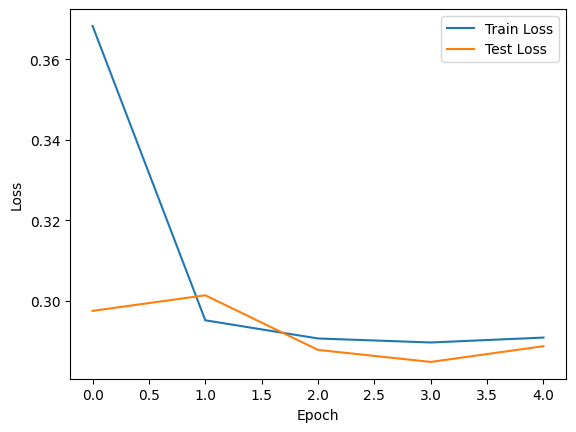

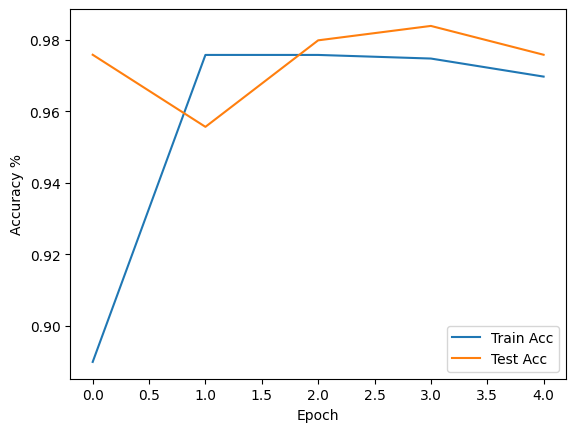

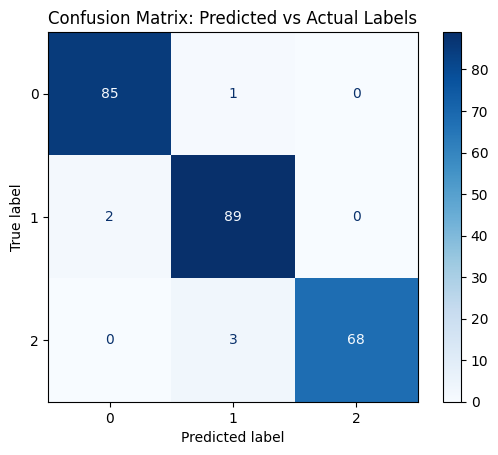

The text provided leans towards right with a probability of 3.7% for left, 90.4% for right, and 5.9% for center.


In [45]:
def main(text,batch_size,num_epochs,verbose,override):

  if nd.nonsense(text):
    raise Exception("Gibberish Text Detected") 
  
  d2v_path='d2v_model'
  nn_path = 'classification_model'

  df = get_data()
  df = process_data(df)
  
  if ((override or not os.path.exists(d2v_path+'.model') or not os.path.exists(nn_path+'.pth')) and verbose):
    display_data(df)

  if(override or not os.path.exists(d2v_path+'.model')):
    d2v_model = create_d2v(d2v_path,df)
  else:
    print("Doc2vec model found & loaded")
    d2v_model = Doc2Vec.load(d2v_path+'.model')
  
  dataset = FBData(df,d2v_model)
  train_loader, test_loader = split_data(dataset,batch_size)

  input_size = d2v_model.vector_size
  hidden_dim_1 = 64
  hidden_dim_2 = 16
  num_classes = 3
  model = BiasClassificationModel(input_size,hidden_dim_1,hidden_dim_2,num_classes)

  if(override or not os.path.exists(nn_path+'.pth')):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)
    criterion = torch.nn.CrossEntropyLoss()
    train_test_loop(nn_path,train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose)
  else:
    model.load_state_dict(torch.load(nn_path+'.pth'))

  if(text is not None):
    predict_text(text,model,d2v_model)

text = "test text test text test text"
main(text,batch_size=2,num_epochs=5,verbose=True,override=True)